In [1]:
%matplotlib inline

from pathlib import Path
import sys
sys.path.append("..")

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv

/home/hadim/local/conda/envs/ws/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


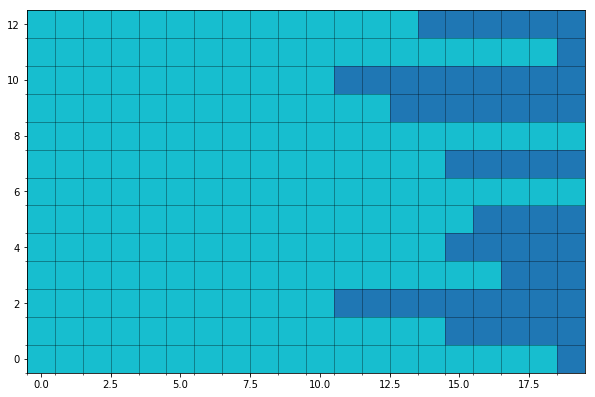

In [2]:
n_pf = 13
n_rows = 20

dimers = np.ones((n_pf, n_rows))
dimers = anamic.structure.generate_random_tapers(dimers, 0, 10)

_ = anamic.viz.viz_dimers(dimers, start_row=0, grid=True)

In [12]:
# Calculate dimer positions
n_pf = dimers.shape[0]
n_rows = dimers.shape[1]

# Get the parameters of geometry structure
# according to the number of pf.
params = anamic.structure.get_structure_parameters().loc[n_pf].to_dict()

mt_radius = ((16.4 * n_pf + 46.8) / 2) / 10
# Equation 6 of Chretien, 1996
skew_angle = - np.arctan((3 * 2 / (13 * 51.5)) - (params['helix_start_number'] * 2 / ( n_pf * 51.5)))
    
positions = []

i_row = 0
for i_pf in range(n_pf):
    datum = {}
    datum['row'] = i_row
    datum['pf'] = i_pf
    datum['helix'] = 0
    datum['x'] = mt_radius * np.sin(i_pf * np.deg2rad(params['hrot']))
    datum['y'] = mt_radius * np.cos(i_pf * np.deg2rad(params['hrot']))
    datum['z'] = i_pf * params['htrans']
    datum['visible'] = False
    datum['visible'] = dimers[i_pf, i_row] == 1
    positions.append(datum)
positions = pd.DataFrame(positions) 

i_helix = 0
for i_row in range(1, n_rows):
    
    initial_row = positions[positions['row'] == 0]
    current_row = initial_row.copy()

    current_row['row'] = i_row

    # Apply translation.
    shift = i_row * 8 * np.cos(skew_angle)
    current_row['z'] += shift
    
    # Apply rotation
    rotation = i_row * (360 - n_pf * params['hrot']) / params['helix_start_number'] * 2
    rotation = np.deg2rad(rotation)
    Rz = anamic.transformations.rotation_matrix(rotation, [0, 0, 1])
    current_row[['x', 'y', 'z']] = np.dot(current_row[['x', 'y', 'z']].values, Rz[:3, :3].T)
    current_row['visible'] = False
    current_row['visible'] = dimers[:, i_row] == 1

    # Add new positions to the list
    positions = positions.append(current_row, ignore_index=True)

anamic.viz.viz_dimer_positions(positions, dimers, size=4, color_feature_name='row')

In [10]:
size = 6
color_feature_name = 'pf'

In [16]:
import matplotlib

# Only show visible dimers
selected_dimers = positions[positions['visible'] == True]

x, y, z = selected_dimers[['x', 'y', 'z']].values.astype('float').T

if color_feature_name:
    cmap = matplotlib.cm.get_cmap('tab20c')
    color = cmap(selected_dimers[color_feature_name].values)
else:
    color = '#e4191b'

ipv.figure(height=800, width=1000)
ipv.scatter(x, y, z, size=size, marker='sphere', color=color)
ipv.squarelim()
ipv.show()